In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
import networkx as nx
from scipy.stats import zscore

# install R and dagitty first: install.packages("dagitty")
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# Import R's dagitty
dagitty = importr('dagitty')

Error importing in API mode: ImportError("dlopen(/Users/aoakley/Library/Mobile Documents/com~apple~CloudDocs/Active_Projects/Dalhousie/AppliedBayes_2025/.venv/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): symbol not found in flat namespace '_R_BaseEnv'")
Trying to import in ABI mode.


# Lab 4 - Conditionality, Interactions and MCMC Diagnostics

**Author:** Arun Oakley-Cogan  
**Date:** 2025-10-10

We have been mentioning throughout the course about conditioning, for example, in your last homework when you built models that conditioned on a simulated variable G. In statistical inference conditioning is everywhere.

-   Data is conditional on the way it makes it into our data set - like the manatees or WW2 bombers.
-   Posterior distributions are conditional on the data.
-   Linear regressions are predicting an outcome, y, conditional on it's predictor variables.

Interactions are a type of conditioning where parameters are conditional on other parameters. There are two types of interactions, categorical and continuous. Today, we are taking a look at how we code up categorical interactions in our linear models, and adding in MCMC convergence diagnostics into our workflow.

## **Bayesian Workflow**

1.  Before fitting a model
    -   Define what we are estimating (Causal Structure)
    -   Choose an initial model / Model construction (lego blocks) / Start Simple
    -   Scale and transform data
    -   Prior predictive simulation
    -   Build generative model to simulate data
2.  Fitting the model
    -   Set initial values for priors
    -   Set chain parameters
    -   Fit the model
3.  Validating the models
    -   Use fake data simulation
4.  *Addressing computation problems - not covered today*
5.  Evaluate model fit
    -   Convergence Diagnostics
    -   Posterior predictive checks
    -   Plot out final linear regression
6.  Modifying the model
    -   Improve data model
    -   Incorporate additional data/predictors
    -   Refine priors distributions
7.  Compare models - if necessary

<!-- -->

Back to our simulated frogs, this time around we also are recording the sex (M/F) of the frog along with its length and weight

**Q1. What is the total effect of Sex on Weight?**

**Q2. What is the direct effect of Sex on Weight?**

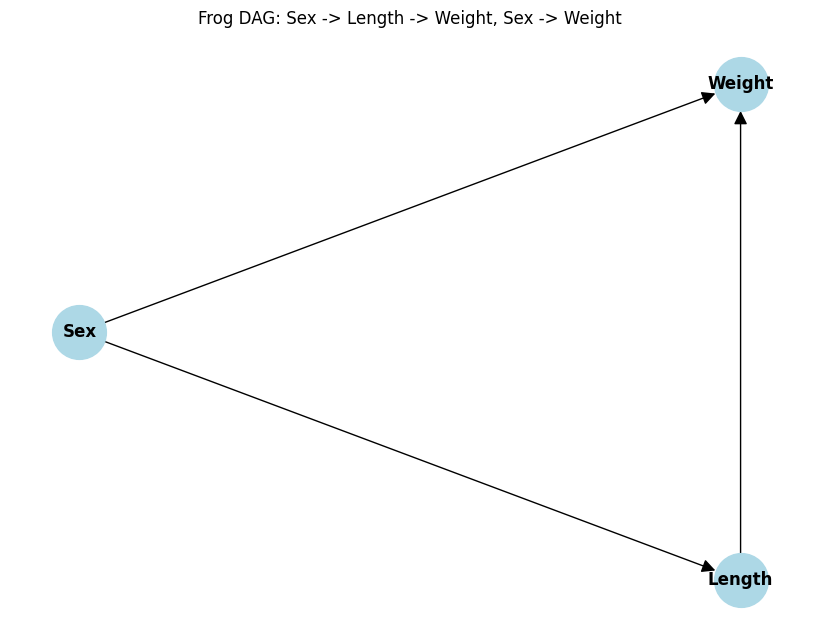

Causal Analysis:
Total effect of Sex on Weight: No adjustment needed (no confounders)
Direct effect of Sex on Weight: Adjust for Length (mediator)


In [2]:
# causal model of our question.
# Manual DAG definition since we can use networkx directly
edges = [('Sex', 'Length'), ('Sex', 'Weight'), ('Length', 'Weight')]

dag_nx = nx.DiGraph(edges)
# set coordinates
pos = {
    'Sex': (0, 0.5),
    'Length': (1, 0),
    'Weight': (1, 1)
}
# draw dag
plt.figure(figsize=(8, 6))
nx.draw(dag_nx, pos, with_labels=True, node_color='lightblue',
        node_size=1500, arrowsize=20, arrows=True, font_size=12, font_weight='bold')
plt.title("Frog DAG: Sex -> Length -> Weight, Sex -> Weight")
plt.show()

# For causal analysis, let's use logic instead of dagitty
print("Causal Analysis:")
print("Total effect of Sex on Weight: No adjustment needed (no confounders)")
print("Direct effect of Sex on Weight: Adjust for Length (mediator)")

Here we are stating that whether a frog is make or female directly effects its Length and its Weight and indirectly effects Weight through Length.

Expressed functionally,

Length = f(Sex)

Weight = f(Length, Sex)\

Here, sex is a categorical variable, frogs are labeled as 'Male' or 'Female' and we can work with this data in one of two ways, creating an indicator variable (assign them a 0 or 1) or an index (assign 1, 2 ,3 .. to however many unique categories you have ). Almost always, you want to be using an index variable as this makes our priors easier to deal with.

We will go through using an index variable to assign numbers to unique categories.\

### Define generative model and simulate data

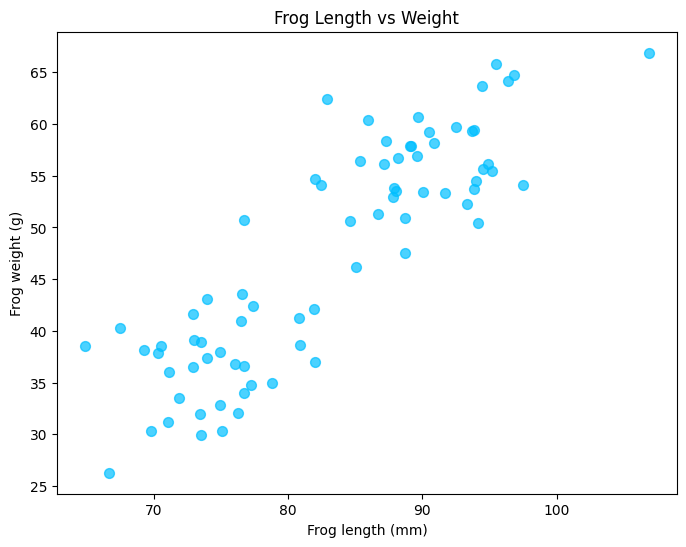

In [3]:
# helper functions
def standardize(x):
    return zscore(x)

# number of frogs
n_frogs = 75

# linear model of lengths and weights.
def simulate_length_weight(sex, b, a):
    n = len(sex)  # get the number of frogs
    # assign lengths of 75 and 90 depending on sex + random variation from our unknown causes
    length = np.where(sex==1, 75, 90) + np.random.normal(0, 5, n)
    # calculate weights based on the length and sex + random variation from our unknown causes
    weight = np.array([a[s-1] for s in sex]) + np.array([b[s-1] for s in sex])*length + np.random.normal(0, 5, n)
    return pd.DataFrame({'sex': sex, 'length': length, 'weight': weight})

# generate our frog sexes, assuming a 50:50 sex ratio in the population
np.random.seed(42)
sex = np.random.choice(['M', 'F'], size=n_frogs, p=[0.5, 0.5])
# assign index variable to Males and Females
sex = np.where(sex=='F', 1, 2)
# simulate data
sim_data = simulate_length_weight(sex, b=[0.5, 0.6], a=[0, 0])

# plot our data
plt.figure(figsize=(8, 6))
plt.scatter(sim_data['length'], sim_data['weight'], color="deepskyblue", alpha=0.7, s=50)
plt.xlabel("Frog length (mm)")
plt.ylabel("Frog weight (g)")
plt.title("Frog Length vs Weight")
plt.show()

In [4]:
# standardize data
model_data = {
    'length': standardize(sim_data['length']), 
    'weight': standardize(sim_data['weight']),
    'sex': sim_data['sex']
}

### Total effect: statistical model

$$
\large{
\begin{align*}
Weight_i \sim Normal(mu_i, sigma)\\
mu_i = alpha[sex]\\
alpha[sex] \sim Normal(0,0.5)\\
sigma \sim Exp(1)
\end{align*}}
$$

In [5]:
with pm.Model() as total_model:
    # priors
    alpha = pm.Normal("alpha", 0, 0.5, shape=2)  # one for each sex
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha[model_data['sex']-1])  # index by sex (subtract 1 for 0-indexing)
    
    # likelihood
    weight_obs = pm.Normal("weight", mu, sigma, observed=model_data['weight'])
    
    # sample
    total_idata = pm.sample(chains=4, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [6]:
# table of posterior estimates
# ess - is our effective sample size, these are the number of independent samples
# taken from the chains
# Rhat - is in an indicator of convergence of the Markov chains to the target 
# distribution, all being well this should equal one
az.summary(total_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.926,0.079,-1.068,-0.772,0.001,0.001,5756.0,2736.0,1.0
alpha[1],0.813,0.073,0.682,0.956,0.001,0.001,5535.0,3124.0,1.0
sigma,0.471,0.040,0.400,0.545,0.001,0.001,5258.0,2989.0,1.0
mu[0],0.813,0.073,0.682,0.956,0.001,0.001,5535.0,3124.0,1.0
mu[1],-0.926,0.079,-1.068,-0.772,0.001,0.001,5756.0,2736.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[70],-0.926,0.079,-1.068,-0.772,0.001,0.001,5756.0,2736.0,1.0
mu[71],0.813,0.073,0.682,0.956,0.001,0.001,5535.0,3124.0,1.0
mu[72],0.813,0.073,0.682,0.956,0.001,0.001,5535.0,3124.0,1.0
mu[73],-0.926,0.079,-1.068,-0.772,0.001,0.001,5756.0,2736.0,1.0


#### Prior predictive simulation

Sampling: [alpha, sigma, weight]


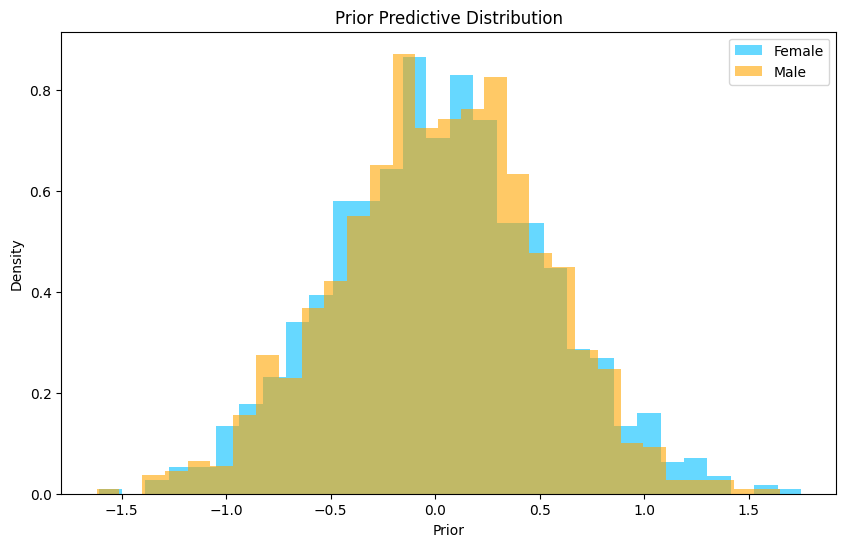

In [7]:
# extract priors
with total_model:
    total_prior = pm.sample_prior_predictive(samples=1000)

# using only priors make predictions on mean
alpha_prior = total_prior.prior['alpha'].values
mu_female = alpha_prior[:, :, 0].flatten()
mu_male = alpha_prior[:, :, 1].flatten()

# plot
plt.figure(figsize=(10, 6))
plt.hist(mu_female, alpha=0.6, bins=30, color="deepskyblue", label='Female', density=True)
plt.hist(mu_male, alpha=0.6, bins=30, color="orange", label='Male', density=True)
plt.xlabel("Prior")
plt.ylabel("Density")
plt.legend()
plt.title("Prior Predictive Distribution")
plt.show()

This looks good. Intercepts are where we expect.

Now lets get into some convergence diagnostics.

In [8]:
# HMC chain diagnostics
# show() - tells you model formula used, and how long each chain took to run
print("Model Summary:")
print(az.summary(total_idata, var_names=['alpha', 'sigma']))

Model Summary:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0] -0.926  0.079  -1.068   -0.772      0.001    0.001    5756.0   
alpha[1]  0.813  0.073   0.682    0.956      0.001    0.001    5535.0   
sigma     0.471  0.040   0.400    0.545      0.001    0.001    5258.0   

          ess_tail  r_hat  
alpha[0]    2736.0    1.0  
alpha[1]    3124.0    1.0  
sigma       2989.0    1.0  


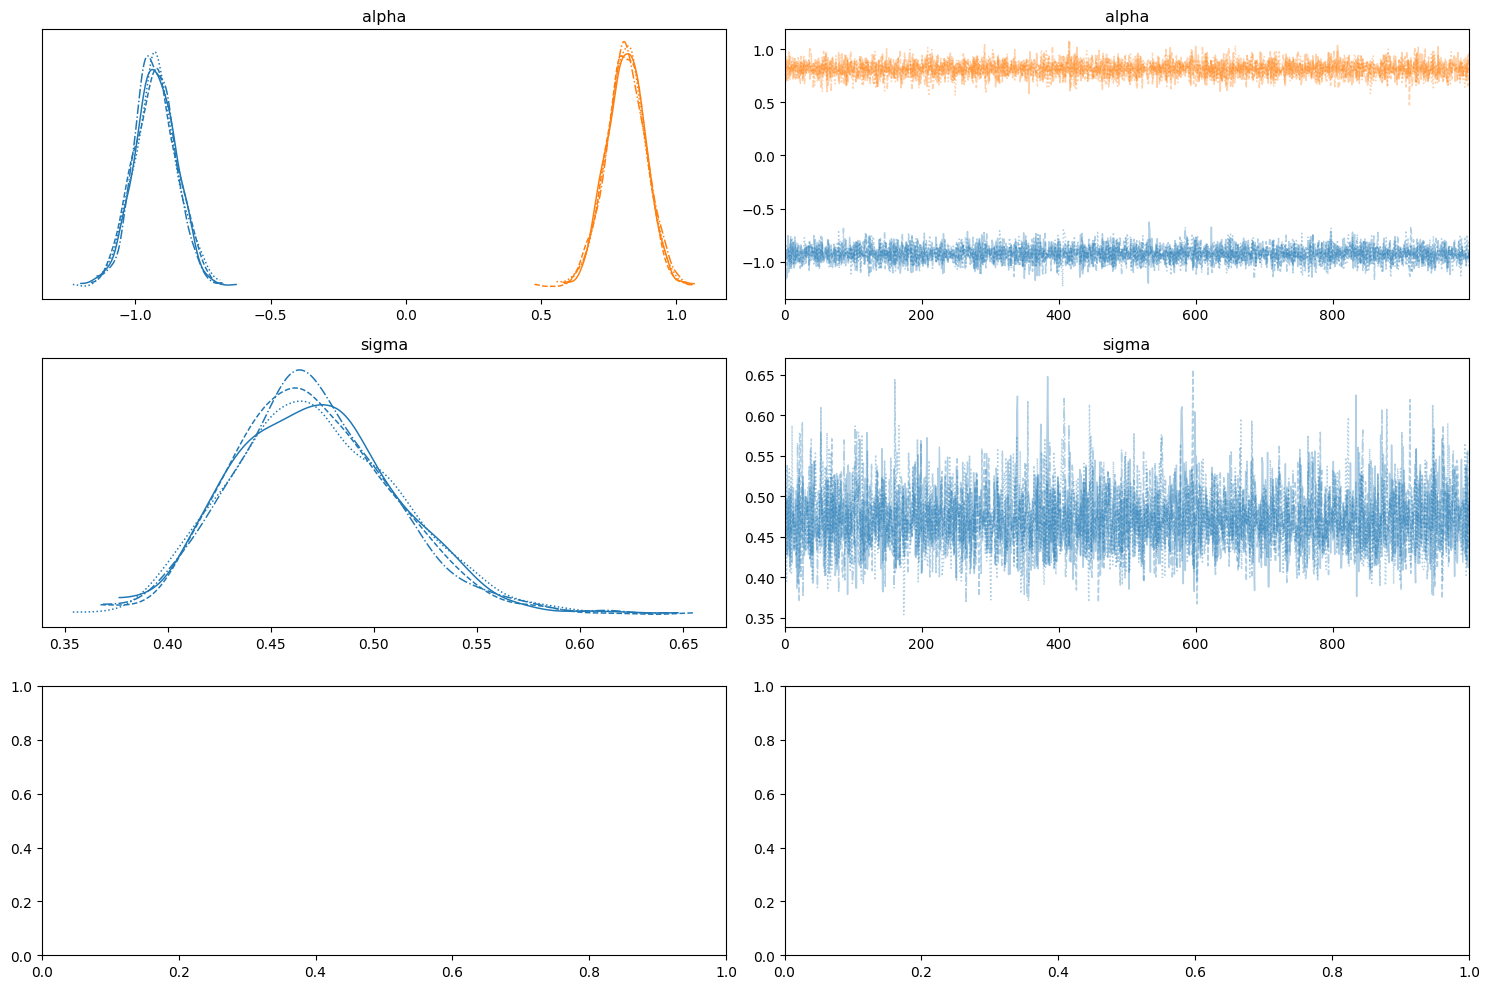

In [9]:
# visualization
# looking for healthy caterpillars
# Trace plot
# stationary, path of a chain stays within the same region of the posterior
# good mixing, chains rapidly explore the full region, it doesn't slowly wander
# convergence, multiple, independent chains stick around the same region
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
az.plot_trace(total_idata, var_names=['alpha', 'sigma'], axes=axes)
plt.tight_layout()
plt.show()

In [10]:
# what does an un-healthy caterpillar look like?
np.random.seed(11)
y = np.array([-1, 1])

with pm.Model() as model_bad:
    alpha = pm.Normal("alpha", 0, 1000)
    sigma = pm.Exponential("sigma", 0.0001)
    
    y_obs = pm.Normal("y", alpha, sigma, observed=y)
    
    bad_idata = pm.sample(chains=3, tune=1000, draws=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, sigma]


Output()

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 11 seconds.
There were 400 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean        sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha  -16.665   429.097 -872.602   885.885     15.771   31.697     821.0   
sigma  836.954  1571.474   30.086  2964.055     77.784  178.934      63.0   

       ess_tail  r_hat  
alpha     668.0   1.04  
sigma      58.0   1.07  


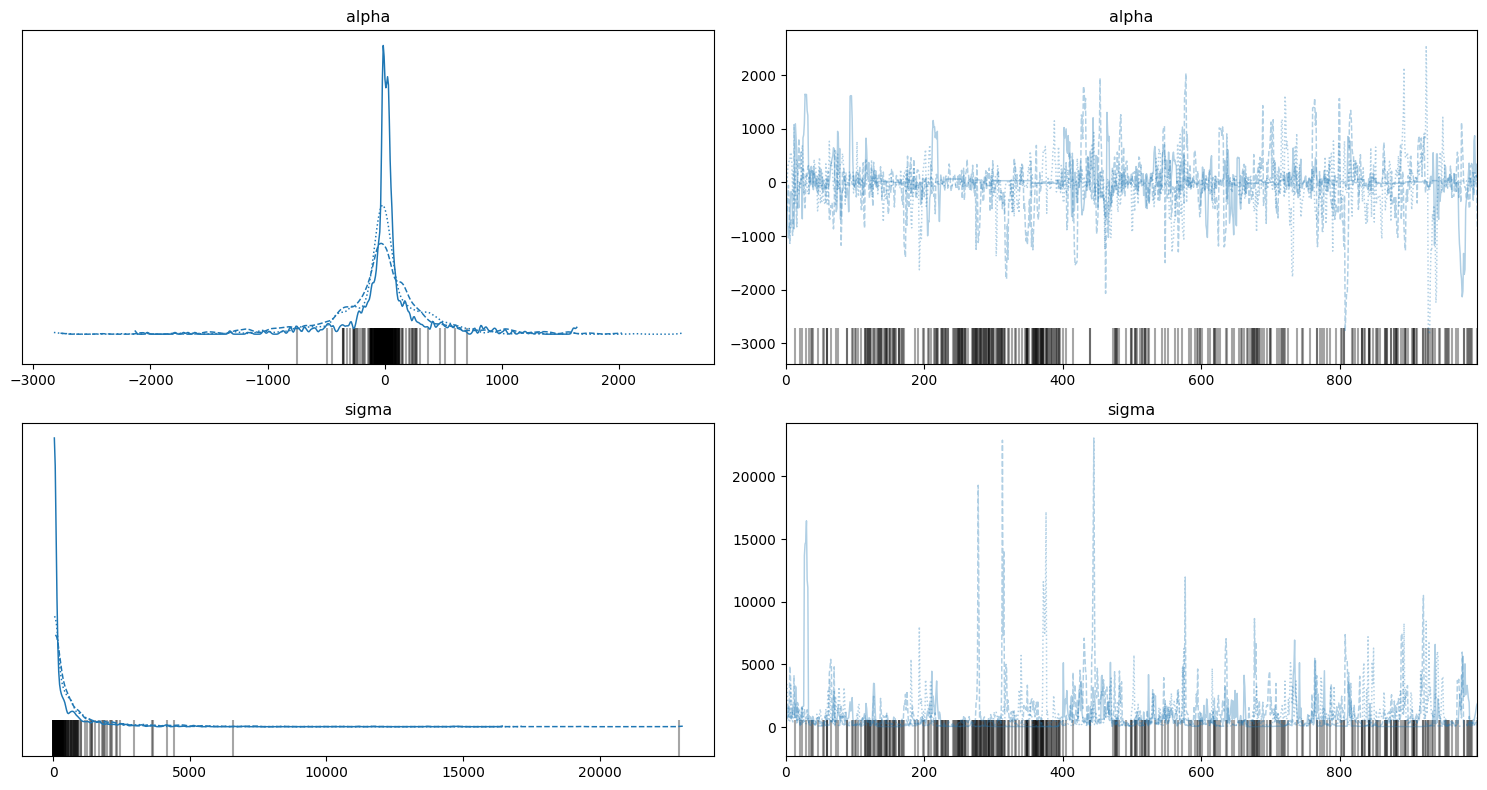

In [11]:
print(az.summary(bad_idata))
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
az.plot_trace(bad_idata, axes=axes)
plt.tight_layout()
plt.show()

#### Posterior Plots

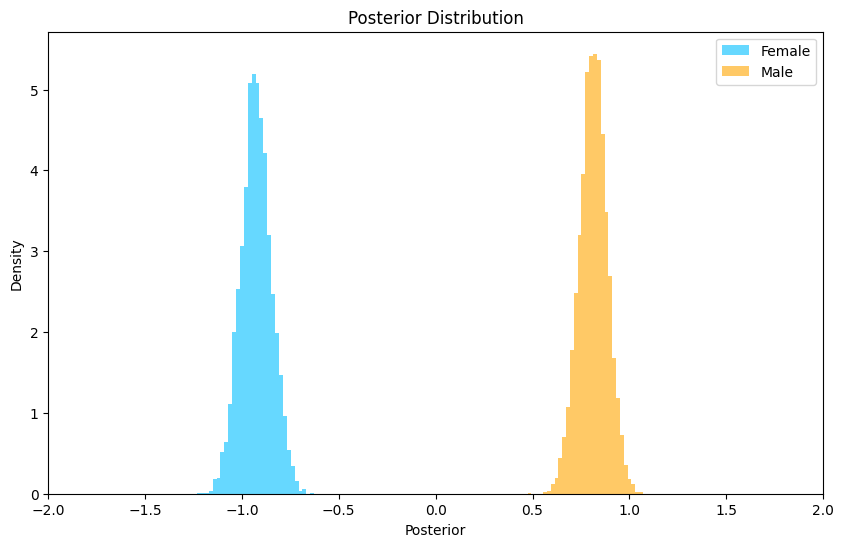

In [12]:
# posterior predictions
alpha_posterior = total_idata.posterior['alpha'].values
mu_female_post = alpha_posterior[:, :, 0].flatten()
mu_male_post = alpha_posterior[:, :, 1].flatten()

# final plot of posteriors
plt.figure(figsize=(10, 6))
plt.hist(mu_female_post, alpha=0.6, bins=30, color="deepskyblue", label='Female', density=True)
plt.hist(mu_male_post, alpha=0.6, bins=30, color="orange", label='Male', density=True)
plt.xlabel("Posterior")
plt.ylabel("Density")
plt.xlim(-2, 2)
plt.legend()
plt.title("Posterior Distribution")
plt.show()

### Direct effect: statistical model

$$
\large{
\begin{align*}
Weight_i \sim Normal(mu_i, sigma)\\
mu_i = alpha[sex] + beta\_l[sex]*Length_i\\
alpha[sex] \sim Normal(0,0.5)\\
beta\_l[sex] \sim Normal(0,0.5)\\
sigma \sim Exp(1)\\
\end{align*}}
$$

In [13]:
with pm.Model() as direct_model:
    # priors
    alpha = pm.Normal("alpha", 0, 0.5, shape=2)
    beta_l = pm.Normal("beta_l", 0, 0.5, shape=2)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha[model_data['sex']-1] + beta_l[model_data['sex']-1] * model_data['length'])
    
    # likelihood
    weight_obs = pm.Normal("weight", mu, sigma, observed=model_data['weight'])
    
    # sample
    direct_idata = pm.sample(chains=4, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_l, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


#### Prior predictive simulation

Sampling: [alpha, beta_l, sigma, weight]


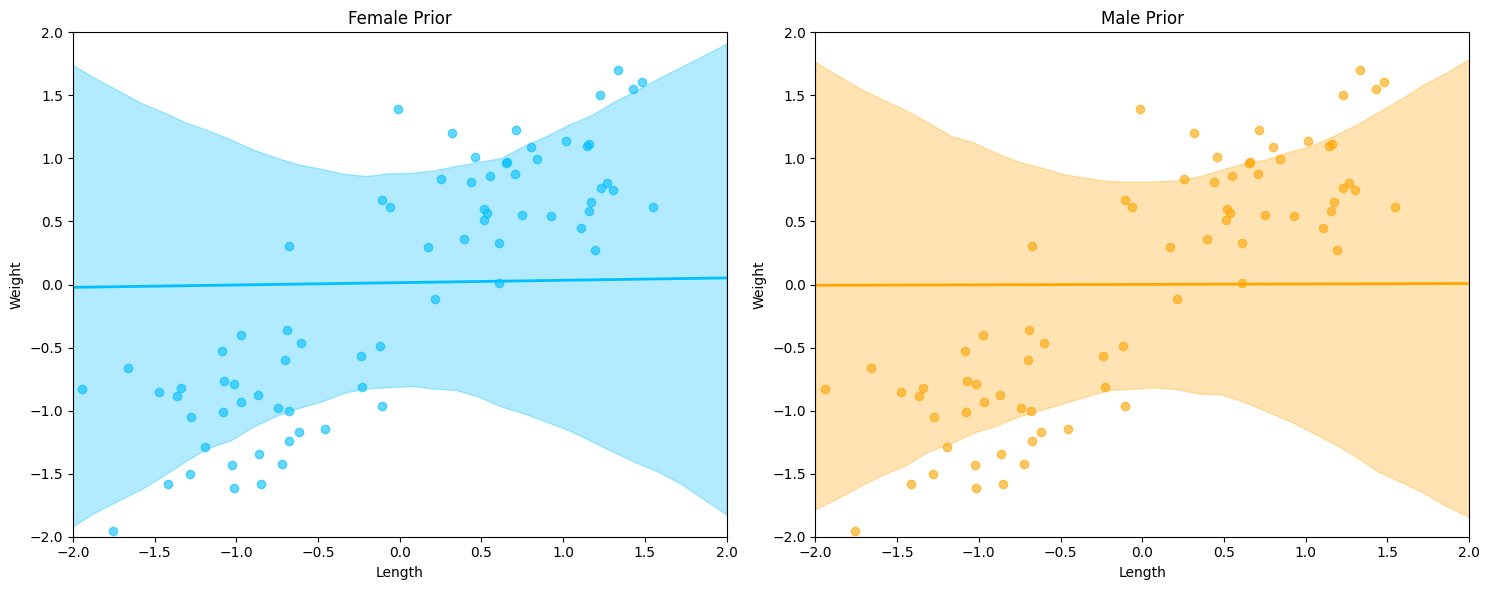

In [14]:
# length sequence for plotting
length_seq = np.linspace(-2, 2, 30)

# extract priors
with direct_model:
    direct_prior = pm.sample_prior_predictive(samples=1000)

# get female priors
alpha_prior = direct_prior.prior['alpha'].values
beta_l_prior = direct_prior.prior['beta_l'].values

f_mu_samples = []
m_mu_samples = []

for i in range(len(length_seq)):
    f_mu = alpha_prior[:, :, 0].flatten() + beta_l_prior[:, :, 0].flatten() * length_seq[i]
    m_mu = alpha_prior[:, :, 1].flatten() + beta_l_prior[:, :, 1].flatten() * length_seq[i]
    f_mu_samples.append(f_mu)
    m_mu_samples.append(m_mu)

f_mu_samples = np.array(f_mu_samples)
m_mu_samples = np.array(m_mu_samples)

f_mu_mean = np.mean(f_mu_samples, axis=1)
f_mu_PI = np.percentile(f_mu_samples, [5, 95], axis=1)

m_mu_mean = np.mean(m_mu_samples, axis=1)
m_mu_PI = np.percentile(m_mu_samples, [5, 95], axis=1)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(model_data['length'], model_data['weight'], color="deepskyblue", alpha=0.6)
ax1.plot(length_seq, f_mu_mean, color="deepskyblue", linewidth=2)
ax1.fill_between(length_seq, f_mu_PI[0], f_mu_PI[1], alpha=0.3, color="deepskyblue")
ax1.set_xlabel("Length")
ax1.set_ylabel("Weight")
ax1.set_title("Female Prior")
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)

ax2.scatter(model_data['length'], model_data['weight'], color="orange", alpha=0.6)
ax2.plot(length_seq, m_mu_mean, color="orange", linewidth=2)
ax2.fill_between(length_seq, m_mu_PI[0], m_mu_PI[1], alpha=0.3, color="orange")
ax2.set_xlabel("Length")
ax2.set_ylabel("Weight")
ax2.set_title("Male Prior")
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)

plt.tight_layout()
plt.show()

We can do better than this, lets try a lognormal distribution to capture the positive relationship in the slope

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betaL, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Sampling: [alpha, betaL, sigma, weight]


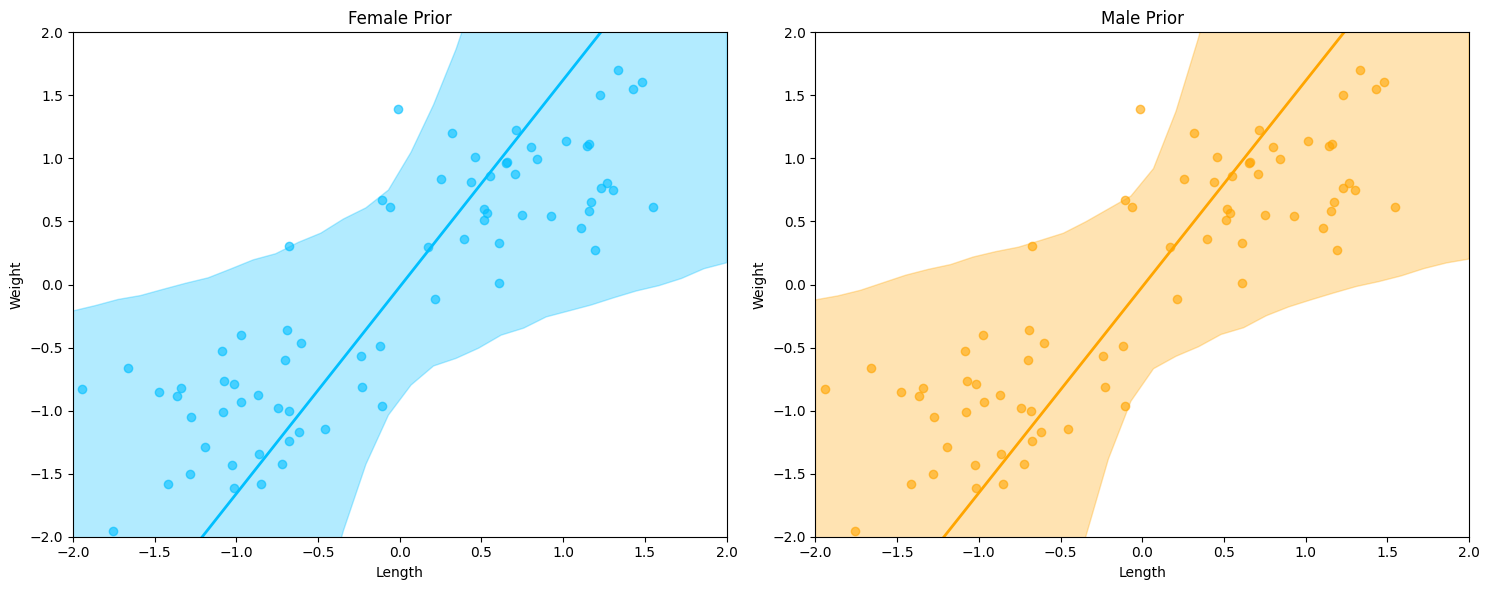

In [15]:
with pm.Model() as direct_model:
    # priors
    alpha = pm.Normal("alpha", 0, 0.5, shape=2)
    betaL = pm.LogNormal("betaL", 0, 1, shape=2)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha[model_data['sex']-1] + betaL[model_data['sex']-1] * model_data['length'])
    
    # likelihood
    weight_obs = pm.Normal("weight", mu, sigma, observed=model_data['weight'])
    
    # sample
    direct_idata = pm.sample(chains=4, idata_kwargs={"log_likelihood": True})

# length sequence for plotting
length_seq = np.linspace(-2, 2, 30)

# extract priors
with direct_model:
    direct_prior = pm.sample_prior_predictive(samples=1000)

# get female priors
alpha_prior = direct_prior.prior['alpha'].values
betaL_prior = direct_prior.prior['betaL'].values

f_mu_samples = []
m_mu_samples = []

for i in range(len(length_seq)):
    f_mu = alpha_prior[:, :, 0].flatten() + betaL_prior[:, :, 0].flatten() * length_seq[i]
    m_mu = alpha_prior[:, :, 1].flatten() + betaL_prior[:, :, 1].flatten() * length_seq[i]
    f_mu_samples.append(f_mu)
    m_mu_samples.append(m_mu)

f_mu_samples = np.array(f_mu_samples)
m_mu_samples = np.array(m_mu_samples)

f_mu_mean = np.mean(f_mu_samples, axis=1)
f_mu_PI = np.percentile(f_mu_samples, [5, 95], axis=1)

m_mu_mean = np.mean(m_mu_samples, axis=1)
m_mu_PI = np.percentile(m_mu_samples, [5, 95], axis=1)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(model_data['length'], model_data['weight'], color="deepskyblue", alpha=0.6)
ax1.plot(length_seq, f_mu_mean, color="deepskyblue", linewidth=2)
ax1.fill_between(length_seq, f_mu_PI[0], f_mu_PI[1], alpha=0.3, color="deepskyblue")
ax1.set_xlabel("Length")
ax1.set_ylabel("Weight")
ax1.set_title("Female Prior")
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)

ax2.scatter(model_data['length'], model_data['weight'], color="orange", alpha=0.6)
ax2.plot(length_seq, m_mu_mean, color="orange", linewidth=2)
ax2.fill_between(length_seq, m_mu_PI[0], m_mu_PI[1], alpha=0.3, color="orange")
ax2.set_xlabel("Length")
ax2.set_ylabel("Weight")
ax2.set_title("Male Prior")
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)

plt.tight_layout()
plt.show()

#### Convergence diagnostics

Model Summary:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0] -0.526  0.143  -0.788   -0.262      0.003    0.002    1786.0   
alpha[1]  0.495  0.115   0.260    0.699      0.003    0.002    1852.0   
betaL[0]  0.451  0.138   0.190    0.703      0.003    0.002    1785.0   
betaL[1]  0.409  0.116   0.187    0.619      0.003    0.002    1850.0   
sigma     0.429  0.037   0.363    0.499      0.001    0.001    2790.0   

          ess_tail  r_hat  
alpha[0]    2027.0    1.0  
alpha[1]    2029.0    1.0  
betaL[0]    1407.0    1.0  
betaL[1]    2035.0    1.0  
sigma       2286.0    1.0  


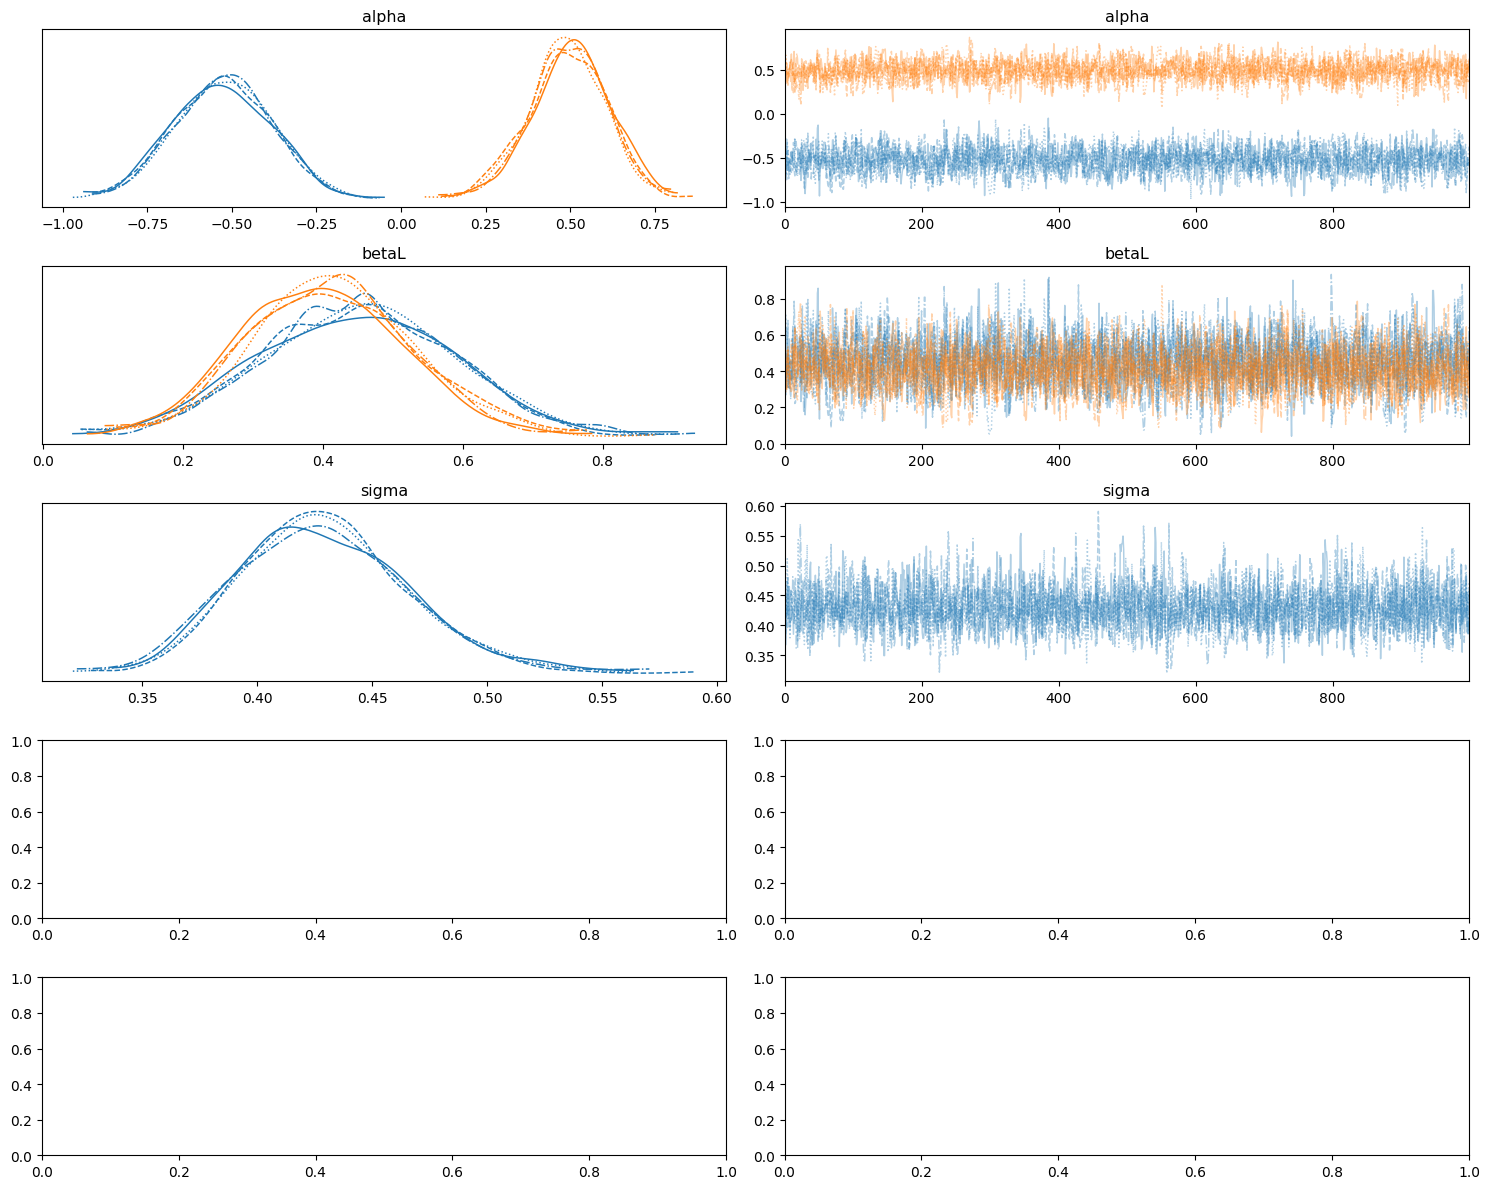

In [16]:
print("Model Summary:")
print(az.summary(direct_idata, var_names=['alpha', 'betaL', 'sigma']))

fig, axes = plt.subplots(5, 2, figsize=(15, 12))
az.plot_trace(direct_idata, var_names=['alpha', 'betaL', 'sigma'], axes=axes)
plt.tight_layout()
plt.show()

#### Posterior predictive

Sampling: [weight]


Output()

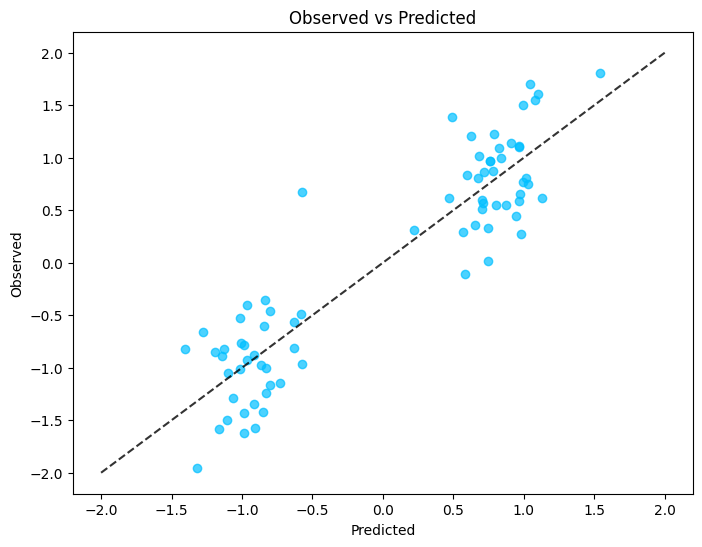

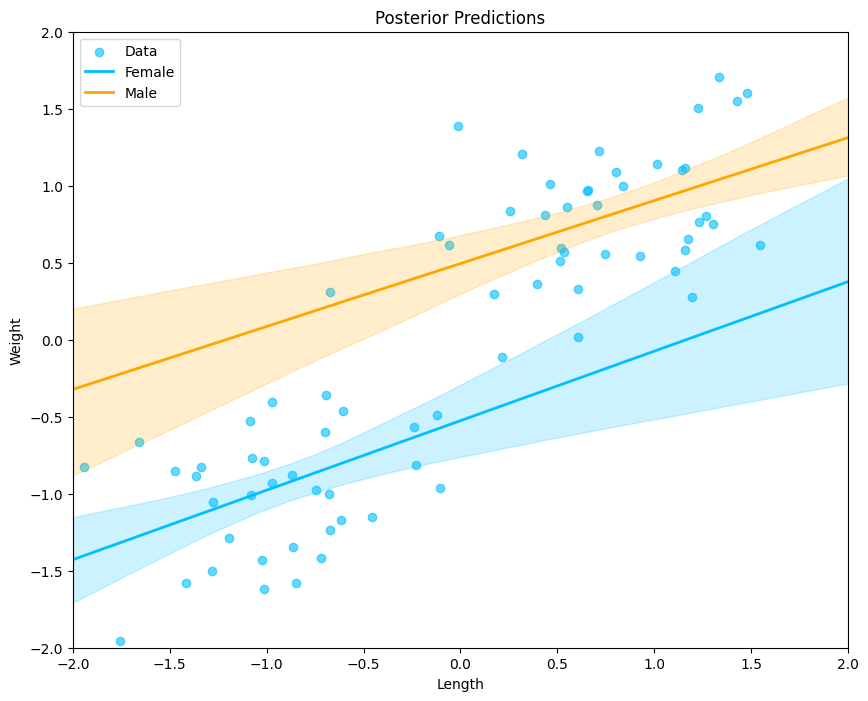

In [17]:
# length sequence for plotting
length_seq = np.linspace(-2, 2, 30)

# get full posterior for observed vs predicted
with direct_model:
    posterior_pred = pm.sample_posterior_predictive(direct_idata, predictions=True)

full_mu_mean = direct_idata.posterior['mu'].mean(dim=['chain', 'draw']).values
full_mu_PI = np.percentile(direct_idata.posterior['mu'].values.reshape(-1, len(model_data['weight'])), [5, 95], axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(full_mu_mean, model_data['weight'], color="deepskyblue", alpha=0.7)
plt.plot([-2, 2], [-2, 2], 'k--', alpha=0.8)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Observed vs Predicted")
plt.show()

# get posterior predictions for plotting
alpha_post = direct_idata.posterior['alpha'].values
betaL_post = direct_idata.posterior['betaL'].values

f_mu_samples = []
m_mu_samples = []

for i in range(len(length_seq)):
    f_mu = alpha_post[:, :, 0].flatten() + betaL_post[:, :, 0].flatten() * length_seq[i]
    m_mu = alpha_post[:, :, 1].flatten() + betaL_post[:, :, 1].flatten() * length_seq[i]
    f_mu_samples.append(f_mu)
    m_mu_samples.append(m_mu)

f_mu_samples = np.array(f_mu_samples)
m_mu_samples = np.array(m_mu_samples)

f_mu_mean = np.mean(f_mu_samples, axis=1)
f_mu_PI = np.percentile(f_mu_samples, [5, 95], axis=1)

m_mu_mean = np.mean(m_mu_samples, axis=1)
m_mu_PI = np.percentile(m_mu_samples, [5, 95], axis=1)

# plot
plt.figure(figsize=(10, 8))
plt.scatter(model_data['length'], model_data['weight'], color="deepskyblue", alpha=0.6, label='Data')
plt.plot(length_seq, f_mu_mean, color="deepskyblue", linewidth=2, label='Female')
plt.fill_between(length_seq, f_mu_PI[0], f_mu_PI[1], alpha=0.2, color="deepskyblue")
plt.plot(length_seq, m_mu_mean, color="orange", linewidth=2, label='Male')
plt.fill_between(length_seq, m_mu_PI[0], m_mu_PI[1], alpha=0.2, color="orange")
plt.xlabel("Length")
plt.ylabel("Weight")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend()
plt.title("Posterior Predictions")
plt.show()